This notebook explains the design of CallFlow's `Ensemble Gradients` which provide an overview of the runtime distribution across a set of executions.

In [1]:
import callflow
from callflow.modules import Gradients
from callflow.operations import ArgParser

Specify the data directory and the format of the profile. 

In [2]:
data_dir = "/Users/jarus/Work/llnl/CallFlow/data/hatchet-datasets/sc19-datasets/lulesh-scaling"
profile_format = "caliper_json"

ArgParser will auto-generate the config file for you.

In [3]:
args = ArgParser("--data_dir " + data_dir + " --profile_format " + profile_format)
config = args.config

Create a CallFlow object which will enable ensemble/single processing and loading operations based on the number of profiles.

In [4]:
cf = callflow.CallFlow(config=config, ensemble=True)

In [6]:
cf.process()

Processing:  lulesh-annotation-profile-27cores


KeyError: 'data'

In [5]:
cf.load()   å

SyntaxError: invalid syntax (<ipython-input-5-a4d980f492db>, line 1)

In [2]:
datasets = list(cf.supergraphs.keys())

NameError: name 'cf' is not defined

In [45]:
target_df = {}
for dataset in datasets:
    if dataset != "ensemble":
        target_df[dataset] = cf.supergraphs['ensemble'].gf.df.loc[cf.supergraphs['ensemble'].gf.df["dataset"] == dataset]


In [48]:
gradients = Gradients(target_df, binCount=20).run(columnName="name", callsiteOrModule="MPI_Allreduce")

In [49]:
print(gradients)

{'Inclusive': {'bins': 20, 'dataset': {'mean': {'lulesh-annotation-profile-27cores': 8744688.666666666, 'lulesh-annotation-profile-64cores': 8372374.84375, 'lulesh-annotation-profile-8cores': 9675005.936, 'lulesh-annotation-profile-1core': 1481.0, 'lulesh-annotation-profile-216cores': 10958018.189814815, 'lulesh-annotation-profile-512cores': 10817060.00390625, 'lulesh-annotation-profile-125cores': 10132928.744, 'lulesh-annotation-profile-343cores': 11322773.618075801}, 'position': {'lulesh-annotation-profile-27cores': 15, 'lulesh-annotation-profile-64cores': 14, 'lulesh-annotation-profile-8cores': 17, 'lulesh-annotation-profile-1core': 0, 'lulesh-annotation-profile-216cores': 19, 'lulesh-annotation-profile-512cores': 19, 'lulesh-annotation-profile-125cores': 17, 'lulesh-annotation-profile-343cores': 19}}, 'hist': {'x': [284513.315451895, 850577.946355685, 1416642.577259475, 1982707.2081632651, 2548771.839067055, 3114836.4699708447, 3680901.1008746354, 4246965.731778425, 4813030.3626822

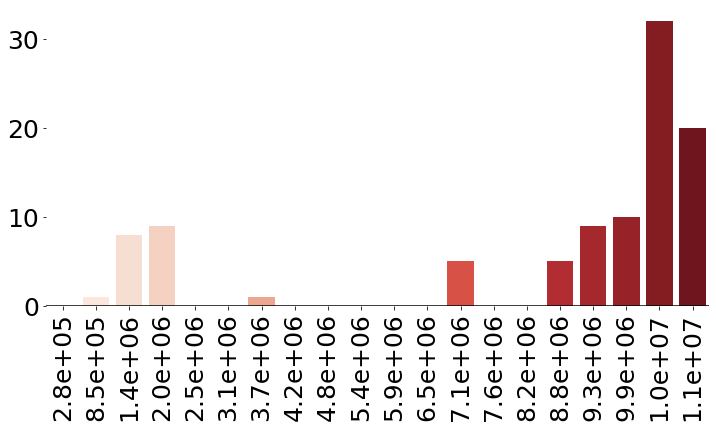

In [139]:
import seaborn as sns
import matplotlib
import matplotlib.ticker as mticker

fig, ax = plt.subplots(1, 1)
fake_data = [0, 1, 8, 9, 0, 0, 1, 0, 0, 0, 0, 0, 5, 0, 0, 5, 9, 10, 32, 20]
boxplot = sns.barplot(x=gradients['Inclusive']['hist']['x'], y=fake_data, palette='Reds')

labels = ['%.1e' % float(t.get_text()) for t in ax.get_xticklabels()]

ax.set_xticklabels(labels, rotation=90)
fig.set_size_inches(10.5, 6.5, forward=True)
sns.despine(left=True)
ax.set_frame_on(False) #Remove both axes
ax.axhline(0, color='black') #Put the x axis back
plt.tight_layout()
matplotlib.rcParams.update({'font.size': 25})
plt.show()




In [50]:
import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as patches

def gradient_fill(x, y, fill_color=None, ax=None, **kwargs):
    """
    Plot a line with a linear alpha gradient filled beneath it.

    Parameters
    ----------
    x, y : array-like
        The data values of the line.
    fill_color : a matplotlib color specifier (string, tuple) or None
        The color for the fill. If None, the color of the line will be used.
    ax : a matplotlib Axes instance
        The axes to plot on. If None, the current pyplot axes will be used.
    Additional arguments are passed on to matplotlib's ``plot`` function.

    Returns
    -------
    line : a Line2D instance
        The line plotted.
    im : an AxesImage instance
        The transparent gradient clipped to just the area beneath the curve.
    """
    if ax is None:
        ax = plt.gca()

    line, = ax.plot(x, y, **kwargs)
    if fill_color is None:
        fill_color = line.get_color()

    zorder = line.get_zorder()
    alpha = line.get_alpha()
    alpha = 1.0 if alpha is None else alpha

    z = np.empty((100, 1, 4), dtype=float)
    rgb = mcolors.colorConverter.to_rgb(fill_color)
    z[:,:,:3] = rgb
    z[:,:,-1] = np.linspace(0, alpha, 100)[:,None]

    xmin, xmax, ymin, ymax = x.min(), x.max(), y.min(), y.max()
    im = ax.imshow(z, aspect='auto', extent=[xmin, xmax, ymin, ymax],
                   origin='lower', zorder=zorder)

    xy = np.column_stack([x, y])
    xy = np.vstack([[xmin, ymin], xy, [xmax, ymin], [xmin, ymin]])
    clip_path = Polygon(xy, facecolor='none', edgecolor='none', closed=True)

    ax.add_patch(clip_path)
    im.set_clip_path(clip_path)

    ax.autoscale(True)
    return line, im


In [51]:
import matplotlib.pyplot as plt

def draw_gradients(x, y, fill_color=None):
    # if ax is None:
    #     ax = plt.gca()

    line, = plt.bar(x, y, color="red")
    verts = [
        (0., 0.),  # left, bottom
        (0., 1.),  # left, top
        (1., 1.),  # right, top
        (1., 0.),  # right, bottom
        (0., 0.),  # ignored
    ]

    codes = [
        Path.MOVETO,
        Path.LINETO,
        Path.LINETO,
        Path.LINETO,
        Path.CLOSEPOLY,
    ]

    path = Path(verts, codes)
    patch = patches.PathPatch(path, facecolor='orange', lw=2)
    ax.add_patch(clip_path)
    return line, im


In [52]:
def main():
    gradient_fill(np.array(gradients['Inclusive']['hist']['x']), np.array(gradients['Inclusive']['hist']['y']))
    draw_gradients(np.array(gradients['Inclusive']['hist']['x']), np.array(gradients['Inclusive']['hist']['y']))
    plt.show()

def generate_data(num):
    x = np.linspace(0, 100, num)
    y = np.random.normal(0, 1, num).cumsum()
    return x, y

main()

NameError: name 'np' is not defined

ValueError: too many values to unpack (expected 1)